In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os

dataset_path = '/content/drive/MyDrive/Tumour'  # adjust if needed
categories = os.listdir(dataset_path)
print("Tumor Categories:", categories)

for category in categories:
    cat_path = os.path.join(dataset_path, category)
    if os.path.isdir(cat_path):
        print(f"{category}: {len(os.listdir(cat_path))} images")


Tumor Categories: ['test', 'README.dataset.txt', 'train', 'valid']
test: 5 images
train: 5 images
valid: 5 images


In [3]:
train_path = os.path.join(dataset_path, 'train')
tumor_types = os.listdir(train_path)
print("Tumor types (classes):", tumor_types)

# Count images per class
for tumor in tumor_types:
    class_path = os.path.join(train_path, tumor)
    if os.path.isdir(class_path):
        print(f"{tumor}: {len(os.listdir(class_path))} images")


Tumor types (classes): ['_classes.csv', 'glioma', 'meningioma', 'no_tumor', 'pituitary']
glioma: 564 images
meningioma: 358 images
no_tumor: 335 images
pituitary: 438 images


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [5]:
train_dir = os.path.join(dataset_path, 'train')
val_dir   = os.path.join(dataset_path, 'valid')
test_dir  = os.path.join(dataset_path, 'test')


In [6]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Validation and test data without augmentation
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Flow data from directories
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


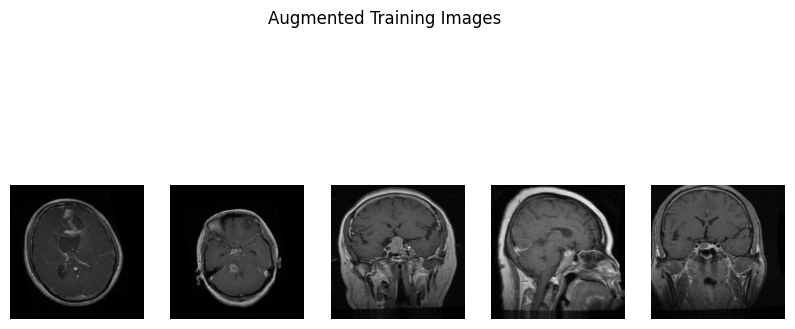

In [7]:
# View some augmented training images
x_batch, y_batch = next(train_gen)

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_batch[i])
    plt.axis('off')
plt.suptitle("Augmented Training Images")
plt.show()


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

num_classes = train_gen.num_classes  # Number of tumor categories

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')  # Final classification layer
])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,372 (42.61 MB)

 Trainable params: 11,169,924 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('custom_cnn_best_model.h5', save_best_only=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=callbacks
)


Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.5830 - loss: 1.1255 

53/53 ━━━━━━━━━━━━━━━━━━━━ 987s 19s/step - accuracy: 0.5829 - loss: 1.1246 - val_accuracy: 0.3745 - val_loss: 5.9287
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 579ms/step - accuracy: 0.6436 - loss: 0.9266 - val_accuracy: 0.4223 - val_loss: 7.7186
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 577ms/step - accuracy: 0.6694 - loss: 0.8027 - val_accuracy: 0.4283 - val_loss: 6.3678
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.6717 - loss: 0.8376

53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 582ms/step - accuracy: 0.6717 - loss: 0.8375 - val_accuracy: 0.4303 - val_loss: 4.0607
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.6806 - loss: 0.8602

53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 635ms/step - accuracy: 0.6809 - loss: 0.8595 - val_accuracy: 0.5578 - val_loss: 2.1360


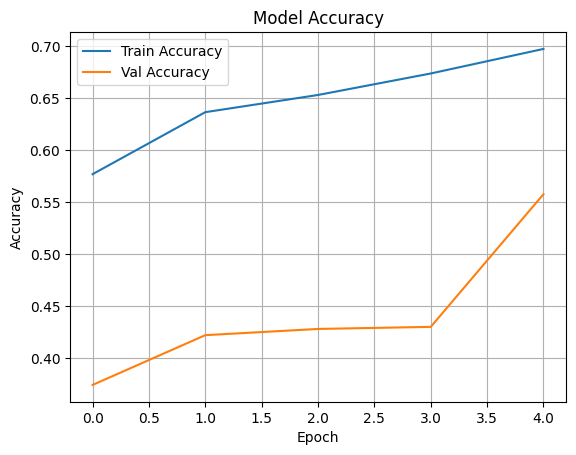

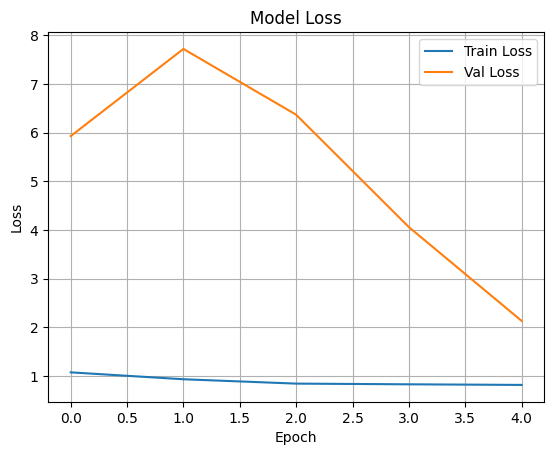

In [14]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
loss, acc = model.evaluate(test_gen)
print(f"Test Accuracy: {acc*100:.2f}%")


8/8 ━━━━━━━━━━━━━━━━━━━━ 155s 22s/step - accuracy: 0.6970 - loss: 1.2839
Test Accuracy: 54.07%


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 428ms/step
              precision    recall  f1-score   support

      glioma       0.56      0.99      0.71        80
  meningioma       0.61      0.22      0.33        63
    no_tumor       0.88      0.14      0.25        49
   pituitary       0.45      0.61      0.52        54

    accuracy                           0.54       246
   macro avg       0.62      0.49      0.45       246
weighted avg       0.61      0.54      0.48       246



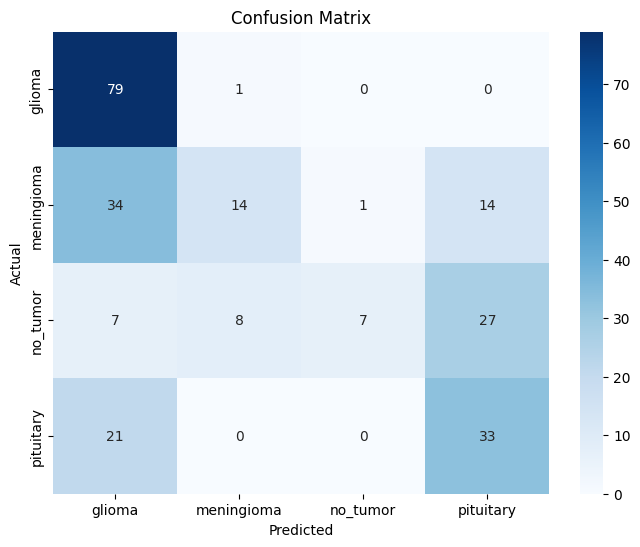

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Predict
y_true = test_gen.classes
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Report
class_labels = list(test_gen.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [17]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Load base model (without top layers)
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base layers initially

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

# Final model
tl_model = Model(inputs=base_model.input, outputs=output)

tl_model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [18]:
tl_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
tl_callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('mobilenetv2_best_model.h5', save_best_only=True)
]

# Train
tl_history = tl_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,  # fewer needed due to pretrained base
    callbacks=tl_callbacks
)


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.4222 - loss: 1.4950

53/53 ━━━━━━━━━━━━━━━━━━━━ 54s 822ms/step - accuracy: 0.4234 - loss: 1.4911 - val_accuracy: 0.6793 - val_loss: 0.8115
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.6500 - loss: 0.8907

53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 623ms/step - accuracy: 0.6505 - loss: 0.8892 - val_accuracy: 0.7410 - val_loss: 0.6510
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.7417 - loss: 0.6847

53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 591ms/step - accuracy: 0.7420 - loss: 0.6839 - val_accuracy: 0.7769 - val_loss: 0.5778
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.7797 - loss: 0.5884

53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 584ms/step - accuracy: 0.7798 - loss: 0.5884 - val_accuracy: 0.7928 - val_loss: 0.5470
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.8124 - loss: 0.5014

53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 581ms/step - accuracy: 0.8123 - loss: 0.5014 - val_accuracy: 0.8088 - val_loss: 0.5069
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 578ms/step - accuracy: 0.8164 - loss: 0.5108 - val_accuracy: 0.7849 - val_loss: 0.5394
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.8253 - loss: 0.4640

53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 578ms/step - accuracy: 0.8256 - loss: 0.4638 - val_accuracy: 0.8127 - val_loss: 0.4838
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.8497 - loss: 0.4131

53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 570ms/step - accuracy: 0.8499 - loss: 0.4128 - val_accuracy: 0.8127 - val_loss: 0.4772
Epoch 9/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 568ms/step - accuracy: 0.8592 - loss: 0.3988 - val_accuracy: 0.7948 - val_loss: 0.5395
Epoch 10/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 44s 622ms/step - accuracy: 0.8628 - loss: 0.3799 - val_accuracy: 0.8167 - val_loss: 0.4929


In [19]:
# Unfreeze the top layers of the base model
base_model.trainable = True

# Optional: freeze first few layers (helps prevent overfitting)
for layer in base_model.layers[:100]:
    layer.trainable = False

# Re-compile the model
tl_model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training (fine-tuning)
fine_tune_history = tl_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=tl_callbacks
)


Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 69s 884ms/step - accuracy: 0.5030 - loss: 1.3235 - val_accuracy: 0.7689 - val_loss: 0.5744
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 566ms/step - accuracy: 0.7133 - loss: 0.7736 - val_accuracy: 0.7390 - val_loss: 0.6626
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 593ms/step - accuracy: 0.7915 - loss: 0.5792 - val_accuracy: 0.7410 - val_loss: 0.7060
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 561ms/step - accuracy: 0.8197 - loss: 0.4646 - val_accuracy: 0.7510 - val_loss: 0.6869
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 571ms/step - accuracy: 0.8338 - loss: 0.4432 - val_accuracy: 0.7610 - val_loss: 0.6587


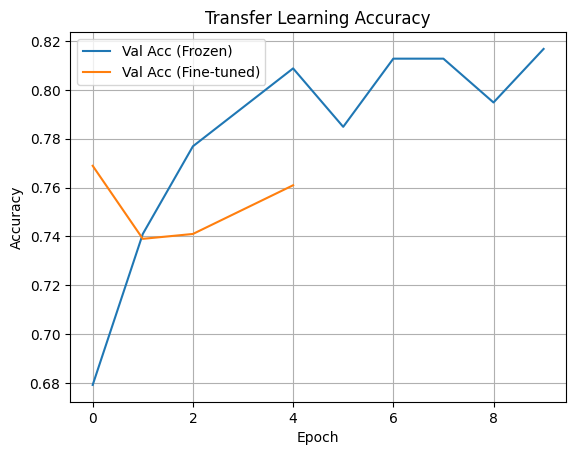

In [20]:
plt.plot(tl_history.history['val_accuracy'], label='Val Acc (Frozen)')
plt.plot(fine_tune_history.history['val_accuracy'], label='Val Acc (Fine-tuned)')
plt.title('Transfer Learning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
loss, acc = tl_model.evaluate(test_gen)
print(f"MobileNetV2 Test Accuracy: {acc*100:.2f}%")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.8249 - loss: 0.4736
MobileNetV2 Test Accuracy: 77.64%


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 722ms/step
              precision    recall  f1-score   support

      glioma       0.70      1.00      0.82        80
  meningioma       0.86      0.38      0.53        63
    no_tumor       0.90      0.73      0.81        49
   pituitary       0.80      0.94      0.86        54

    accuracy                           0.78       246
   macro avg       0.81      0.77      0.76       246
weighted avg       0.80      0.78      0.75       246



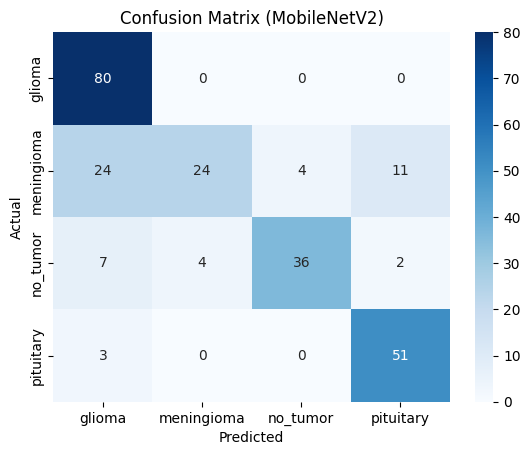

In [22]:
y_pred = tl_model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (MobileNetV2)')
plt.show()


In [23]:
from google.colab import files
files.download('mobilenetv2_best_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>